In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    '''
    Level of similarity of two images
    Dice Coeff = 2*|A∩B|/(|A|+|B|)
    Between 0
    '''
    y_pred = (y_pred > 0.5)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

'''def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)'''


'def dice_loss(y_true, y_pred):\n    return 1 - dice_coefficient(y_true, y_pred)'

In [4]:
def unet_model(input_size=(256, 256, 1)):
    '''
    4 encoder, 4 decoder layers, 1 bottleneck layer
    Output: softmax-probabilities for each pixel to be a tumor
    We set a threshold for the output
    '''
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [2]:
def load_data():
    data_path = "/content/drive/MyDrive/Colab Notebooks/InteractiveML/data/new_data"
    x_new = []
    y_new = []

    imgs_folder = os.path.join(data_path, "imgs")
    labels_folder = os.path.join(data_path, "labels")

    for img_name in sorted(os.listdir(imgs_folder)):
        img_path = os.path.join(imgs_folder, img_name)
        img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_array = image.img_to_array(img) / 255.0
        x_new.append(img_array)

    for img_name in sorted(os.listdir(labels_folder)):
        label_path = os.path.join(labels_folder, img_name)
        label_img = image.load_img(label_path, target_size=(256, 256), color_mode='grayscale')
        label_array = image.img_to_array(label_img) / 255.0
        y_new.append(label_array)

    x_new = np.array(x_new)
    y_new = np.array(y_new)

    return x_new, y_new

In [6]:
x_new, y_new = load_data()

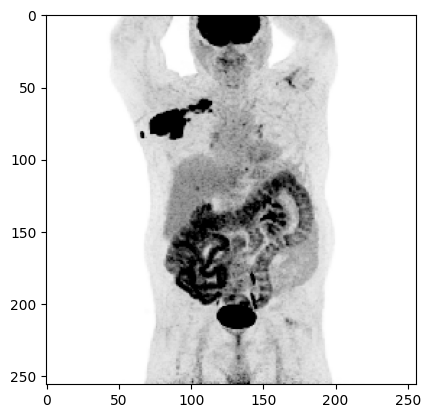

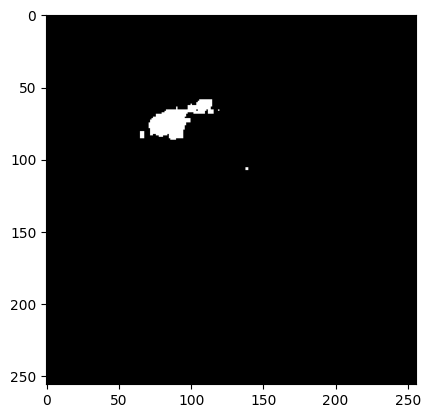

In [7]:
plt.figure()
plt.imshow(x_new[1], cmap='gray')
plt.show()
plt.figure()
plt.imshow(y_new[1], cmap='gray')
plt.show()

In [8]:
model_new = unet_model()
model_new.load_weights('/content/drive/MyDrive/Colab Notebooks/InteractiveML/model.weights.h5')

In [10]:
for layer in model_new.layers[:-5]:
    layer.trainable = False

In [12]:
model_new.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=[dice_coefficient])


history = model_new.fit(
    x_new, y_new,
    epochs=3,
    batch_size=1,
    verbose=1
)


model_new.save_weights('/content/drive/MyDrive/Colab Notebooks/InteractiveML/model_finetuned.weights.h5')

Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - dice_coefficient: 0.6023 - loss: 0.0115
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coefficient: 0.4900 - loss: 0.0115
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coefficient: 0.6703 - loss: 0.0076


In [23]:
def load_test_data():
    data_path = "/content/drive/MyDrive/Colab Notebooks/InteractiveML/data/new_test_data"
    x_new = []
    y_new = []

    imgs_folder = os.path.join(data_path, "imgs")
    labels_folder = os.path.join(data_path, "labels")

    for img_name in sorted(os.listdir(imgs_folder)):
        img_path = os.path.join(imgs_folder, img_name)
        img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_array = image.img_to_array(img) / 255.0
        x_new.append(img_array)

    for img_name in sorted(os.listdir(labels_folder)):
        label_path = os.path.join(labels_folder, img_name)
        label_img = image.load_img(label_path, target_size=(256, 256), color_mode='grayscale')
        label_array = image.img_to_array(label_img) / 255.0
        y_new.append(label_array)

    x_new = np.array(x_new)
    y_new = np.array(y_new)

    return x_new, y_new

In [24]:
x_test, y_test = load_data()

In [25]:
predictions = model_new.predict(x_test)
predictions = (predictions > 0.4).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


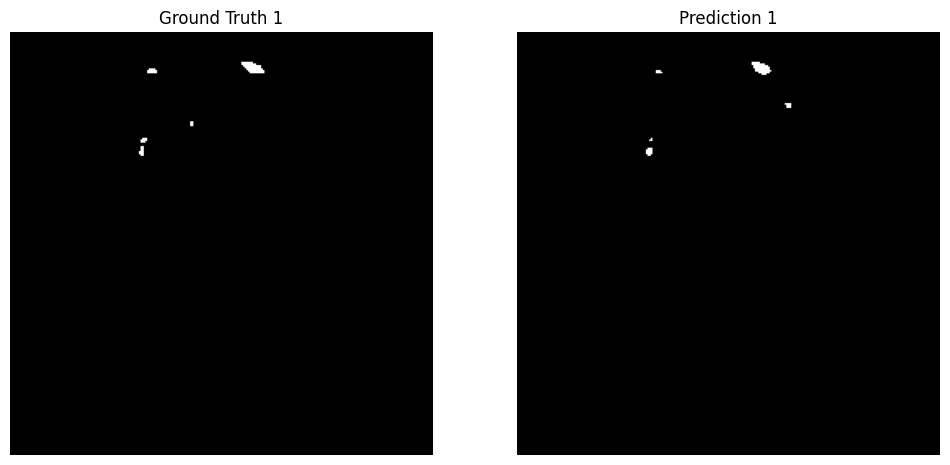

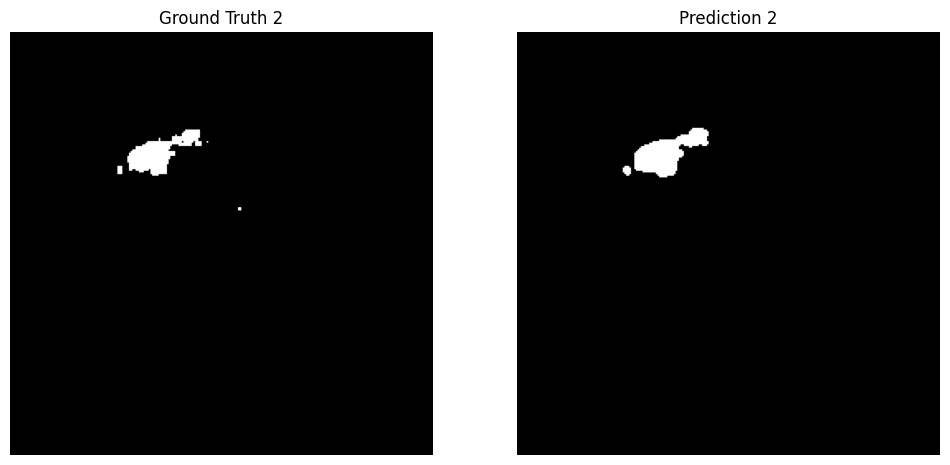

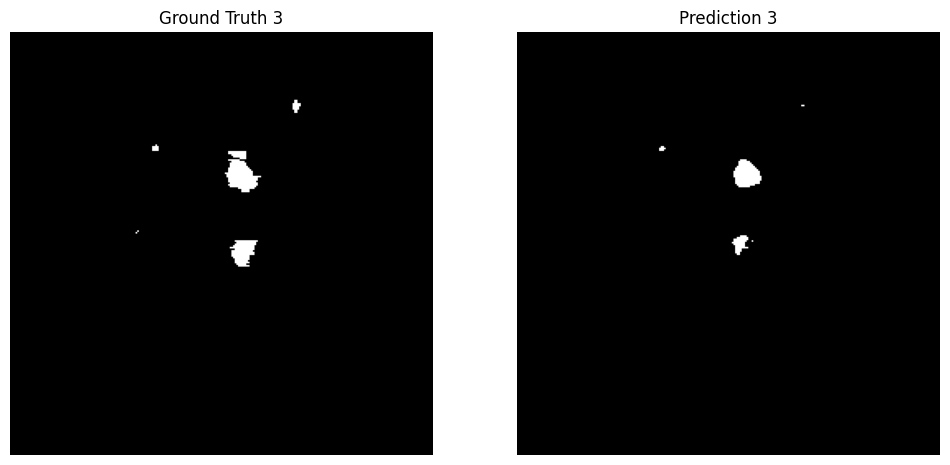

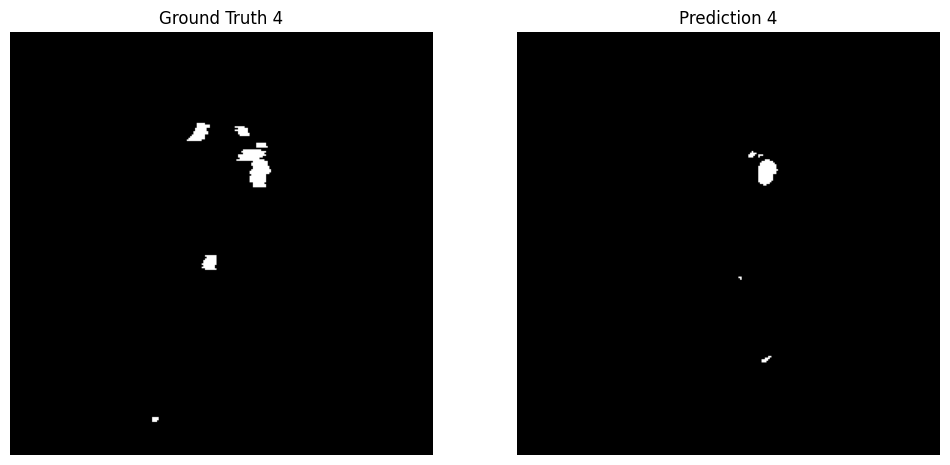

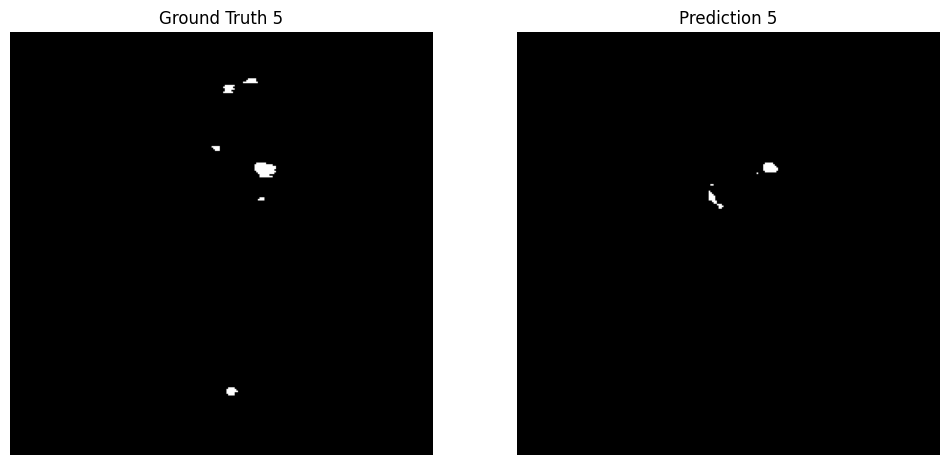

Average Dice Coefficient: 0.6076523840427399


In [26]:
total_dice_coeff = 0.0
num_images = len(x_test)

for i in range(num_images):
      y_true = y_test[i]
      y_pred = predictions[i]

      dice_coeff = dice_coefficient(y_true, y_pred).numpy()
      total_dice_coeff += dice_coeff

      if i < num_images:
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.imshow(y_true.squeeze(), cmap='gray')
          plt.title(f'Ground Truth {i+1}')
          plt.axis('off')

          plt.subplot(1, 2, 2)
          plt.imshow(y_pred.squeeze(), cmap='gray')
          plt.title(f'Prediction {i+1}')
          plt.axis('off')

          plt.show()

average_dice_coeff = total_dice_coeff / num_images
print(f"Average Dice Coefficient: {average_dice_coeff}")